<h1>🤖 MLAI Workshop #02</h1>

In the previous workshop, we explored a foundational drive behind machine learning — thinking of it not just as code or models, but as a process of learning functions under constraints such as hypothesis, data and optimization. We emphasized the importance of the hypothesis space, how data shapes learning, and where errors can arise even when everything seems to be working correctly. Today, we’ll start to address some limitations of our prior models and try to interpret the limitations in the context of the theory - and consequently, what we can do to address it.

💬 *Question for the audience! Have you ever trained a model that just... wouldn’t learn — and you weren’t sure why? What do you think the cause of failure was?*

<h2>🗓️ Agenda</h2>

1. ...
2. ...
3. ...


<h2>Summary</h2>

1. Machine learning is the task of approximating an unknown function using data.
2. Hypothesis Space: We define a family of functions (e.g. linear models, neural networks) that we’re willing to consider - this results in approximation error.
3. Data as Constraints: Each data point reduces the set of plausible functions by adding constraints - this results in generalization error.
4. Optimization: We use methods like gradient descent to minimize loss and fit the data - this results in optimization error.


---

<h2>📈 Section 1: What's wrong with our hypothesis space?</h2>

So we suppose we have some target function we want to approximate.

\begin{align*}
  f^{*}(x) = \left\{ \mathbb{R} \rightarrow \mathbb{R} \,|\, f(x) = -0.86 x + 1.4 \right\} \tag{1.1}
\end{align*}

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# target function
def f_target(x):
    return -0.68 * x + 1.4

We assume we cannot access this function, but we can observe its behaviour - and thus we decide to collect a dataset that hopefully captures this functions behaviour.

\begin{align*}
    \mathcal{D} = \left\{ (\mathcal{X}_{i}, \mathcal{Y}_{i}) \right\}_{i=0}^{N} \tag{1.2}
\end{align*}

where:
- $\mathcal{X}_{i}$ represents an observation of the input.
- $\mathcal{Y}_{i}$ represents an observation of the output.

Text(0, 0.5, 'y_obs')

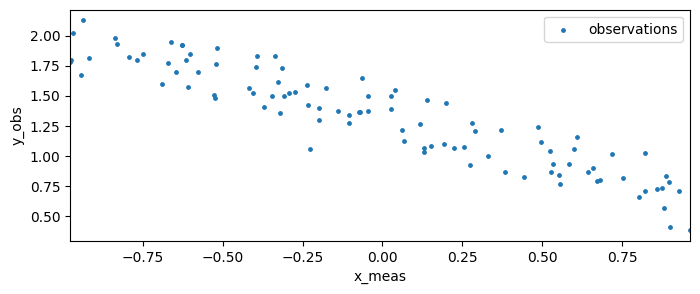

In [51]:
# observe some data using a noisy observation process
def observe_noisy(f, x):
    # we often can't sample perfectly a point in the domain perfectly
    x_noise = np.random.normal(0.05, 0.02, x.shape[0])
    x_measure = x + x_noise

    # we often can't measure the result perfectly
    y_noise = np.random.normal(-0.05, 0.15, x.shape[0])
    y_obs = f(x_measure) + y_noise

    return y_obs

# we select some points to observe the response at
x_meas = np.random.uniform(low=-1, high=1, size=100)
y_obs = observe_noisy(f_target, x_meas)

# plot the observations
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(x_meas, y_obs, s=6, label="observations")
ax.set_xlim(x_meas.min(), x_meas.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

After some exploratory data analysis we might hypothesize this function has a linear relationship, and we design a very specific constricted hypothesis space to match this:

\begin{align*}
    \mathcal{H} = \left\{ f_{\theta}: \mathbb{R} \to \mathbb{R} \,|\, f_{\theta}(x) = \theta_{1} x + \theta_{2} \right\} \tag{1.3}
\end{align*}


In [52]:
# construct a hypothesis space
def H(a, b):
    def f(x):
        return a * x + b
    return f

To provide an empirical evaluation of the fit of our function we define a loss function that meaningfully evaluates the task we want our model to perform:

\begin{align*}
    \mathcal{L}(\mathcal{D}, f_\theta) = \frac{1}{n} \sum_{i=1}^{n} \ell\left(\hat{y}_{i}, y_i\right) = \frac{1}{n} \sum_{i=1}^{n} \ell\left(f_\theta(x_i), y_i\right) \tag{1.4}
\end{align*}

In [53]:
# define a loss function
def dataset_avg_mse_loss(f, x, y):
    # compute average mse loss between prediction `f(x)` and observation `y`
    L = np.sum((f(x) - y) ** 2) / x.shape[0]
    return L

# evaluate a specific model
L_mse = dataset_avg_mse_loss(H(1,1), x_meas, y_obs)
L_mse

np.float64(1.01186947194875)

We then also define the target spaces as a constraint on our set of approximations we consider useful:

\begin{align*}
    \mathcal{T} = \left\{ f \in \mathcal{H} \,|\, \mathcal{L}(\mathcal{D}, f_{\theta} \leq \epsilon) \right\} \tag{1.5}
\end{align*}

In [54]:
# function to check if the solution is suitable
def is_suitable(L_mse, threshold):
    return L_mse < threshold

Since we have a simple model we can visualize the loss landscape in a meaningful manner before we begin the optimization process.

Text(0.5, 0.92, 'Loss Landscape')

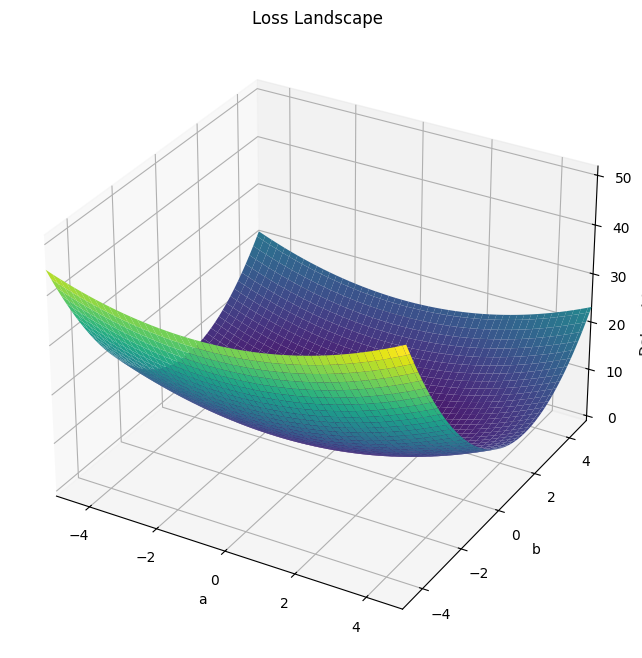

In [55]:
# visualize the loss landscape for understanding
a = np.linspace(-5, 5, num=100) # <-- explore a different range, does [-5,5] let you find the optimal solution?
b = np.linspace(-5, 5, num=100)
A, B = np.meshgrid(a, b, indexing="ij")

# lets compute the loss (error across the dataset) for each function defined by the parameter
losses = np.zeros_like(A)
for i in range(a.shape[0]):
    for j in range(b.shape[0]):
        # select a function from the hypothesis space
        f_approx = H(a=a[i], b=b[j])

        # compute loss across dataset
        losses[i,j] = dataset_avg_mse_loss(f_approx, x_meas, y_obs)

# lets plot the result
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")
s = ax.plot_surface(A, B, losses, cmap='viridis')
ax.set_xlim(a.min(), a.max())
ax.set_ylim(b.min(), b.max())
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_zlabel("Dataset Loss (MSE)")
ax.set_title(f"Loss Landscape")

We can define the gradients of our loss function with respect to each parameter of our model, which we then use in the gradient descent algorithm.

\begin{align*}
\theta := \theta - \eta \cdot \nabla_\theta \mathcal{L}(f_\theta(x), y) \tag{1.6}
\end{align*}

In [56]:
# derivate of function with respect to parameters
def df_da(x, a, b):
    return x

def df_db(x, a, b):
    return 1

# derivate of loss function with respect to params : chain rule
def dL_dtheta(x, y, a, b):
    dL_da = 2 * np.mean((H(a, b)(x) - y) * df_da(x, a, b))
    dL_db = 2 * np.mean((H(a, b)(x) - y) * df_db(x, a, b))
    return (dL_da, dL_db)

We start our optimization process at some initial point on the loss landscape $(\theta_{0}, \theta_{1})$, using the gradient information we then update the parameter values by $\nabla_\theta \mathcal{L}(f_\theta(x), y)$ where $\nabla_\theta$ represents a scaling of the gradients. We repeat this process for $N$ steps.

In [57]:
# optimization using gradient descent
def gradient_descent(a_init, b_init, x, y, lr, steps):
    a, b = a_init, b_init
    history = []

    for idx in range(steps):
        # compute gradients
        dL_da, dL_db = dL_dtheta(x, y, a, b)

        # curr loss
        L_mse = dataset_avg_mse_loss(H(a, b), x, y)
        history.append((a, b, L_mse))

        # gradient descent update step
        a = a - lr * dL_da
        b = b - lr * dL_db

    return np.array(history)

# run gradient descent and get final parameters
trajectory = gradient_descent(a_init=.0, b_init=.0, x=x_meas, y=y_obs, lr=0.1, steps=100, )
f_approx = H(trajectory[-1,0], trajectory[-1,1])

# exit condition : found suitable solution
if is_suitable(trajectory[-1,-1], 0.01): print(f"found suitable solution with loss L={trajectory[-1,-1]:.3f}")

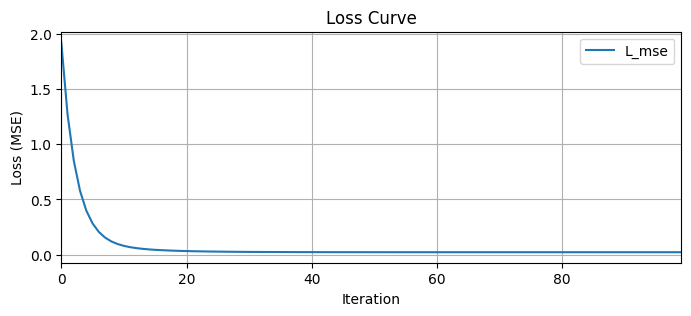

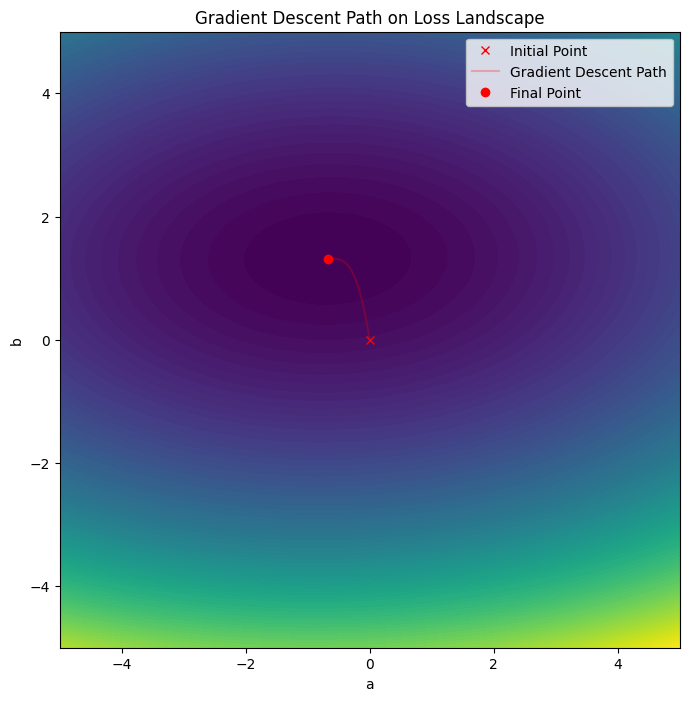

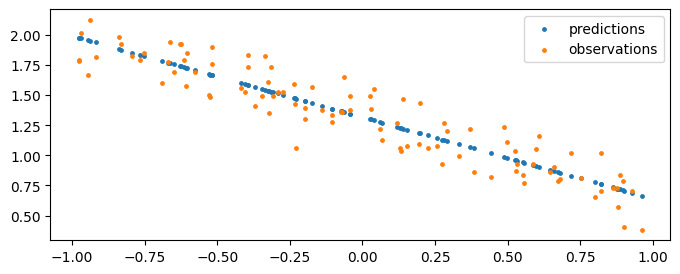

In [58]:
# Plot loss over iterations
fig, ax = plt.subplots(figsize=(8,3))
ax.plot(trajectory[:, 2], label="L_mse")
ax.set_xlim(left=0, right=len(trajectory)-1)
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Loss Curve")
ax.grid(True)
ax.legend()

# Plot the path on the loss landscape
fig, ax = plt.subplots(figsize=(8, 8))
contour = ax.contourf(A, B, losses, levels=100, cmap='viridis')
ax.set_xlim(A.min(), A.max())
ax.set_ylim(B.min(), B.max())
ax.set_xlabel("a")
ax.set_ylabel("b")
ax.set_title("Gradient Descent Path on Loss Landscape")

# Path
ax.plot(trajectory[0, 0], trajectory[0, 1], 'rx', label="Initial Point")
ax.plot(trajectory[:, 0], trajectory[:, 1], 'r-', alpha=0.25, label="Gradient Descent Path")
ax.plot(trajectory[-1, 0], trajectory[-1, 1], 'ro', label="Final Point")
ax.legend()

# Plot predictions
fig, ax = plt.subplots(figsize=(8, 3))
ax.scatter(x_meas, f_approx(x_meas), s=6, label="predictions")
ax.scatter(x_meas, y_obs, s=6, label="observations")
ax.legend(loc="best")

Building everything from scratch helps us understand the mechanics of learning, but it quickly becomes tedious and error-prone as our models grow in complexity. Thankfully, libraries such as `torch` come with all of the functionality we need out of the box e.g the `autograd` engine to handle gradient computation.

Let's convert this code over into a `torch` style implementation.

In [59]:
import torch
import torch.nn as nn
from typing import Callable

class Dataset:
    def __init__(self, f: Callable, a: float, b: float, N = 100):
        self.__f = f
        self.x = torch.from_numpy(np.random.uniform(low=a, high=b, size=N)).to(dtype=torch.float32)
        self.y = torch.from_numpy(observe_noisy(self.__f, self.x.numpy())).to(dtype=torch.float32)
        self.x = self.x.unsqueeze(-1) # [N,1]
        self.y = self.y.unsqueeze(-1) # [N,1]

        # <-- define some additional processing
        # self.x = (self.x - self.x.min()) / (self.x.max() - self.x.min())
        # self.y = (self.y - self.y.min()) / (self.y.max() - self.y.min())

# define a dataset
dataset = Dataset(f=f_target, a=-2, b=2, N=100)

dataset.x.shape

torch.Size([100, 1])

In [60]:
import torch
import torch.nn as nn

class HypothesisSpace(nn.Module):
    """ implement a simple linear equation hypothesis space
    f(x) = a * x + b
    """
    def __init__(self, a: float, b: float):
        super().__init__()
        self.a = nn.Parameter(torch.tensor([a]))
        self.b = nn.Parameter(torch.tensor([b]))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.a * x + self.b

In [62]:
from tqdm import tqdm

# define the optimization loop aka. training loop
def training_loop(model, optimizer, loss_fn, x, y, steps):
    losses = []
    with tqdm(range(steps)) as pbar:
      for idx in pbar:
          optimizer.zero_grad()
          loss = loss_fn(y, model(x))
          losses.append(loss)
          loss.backward()
          optimizer.step()
          pbar.set_description(f"loss: {loss.item():.3f}")
    return model, torch.tensor(losses)

In [63]:
# convert dataset to tensors
x_meas_tensor = torch.from_numpy(x_meas)
y_obs_tensor = torch.from_numpy(y_obs)

# initial model
model = HypothesisSpace(1.0, 1.0)

# define optimizer : autograd handles computing gradients etc.
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# define loss function
loss_fn = torch.nn.MSELoss()

# perform the training loop
model, losses = training_loop(model, optimizer, loss_fn, x_meas_tensor, y_obs_tensor, 100)
if is_suitable(losses[-1], 0.01): print(f"found suitable solution with loss L={losses[-1]:.3f}")

loss: 0.023: 100%|██████████| 100/100 [00:00<00:00, 546.38it/s]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

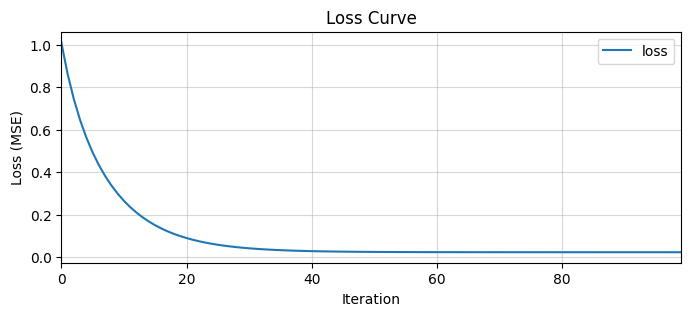

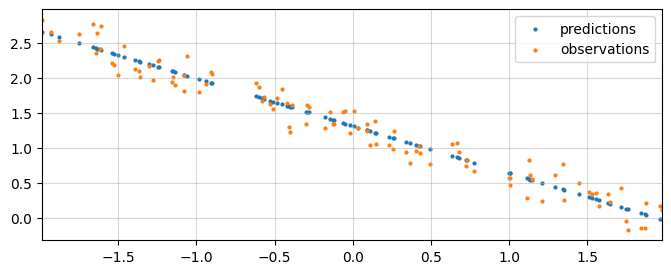

In [65]:
def plot_loss_curve(losses):
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(losses, label="loss")
    ax.set_xlim(left=0, right=len(losses)-1)
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Loss (MSE)")
    ax.set_title("Loss Curve")
    ax.grid(True, alpha=0.50)
    ax.legend()
    return fig, ax

def plot_predictions(model, dataset):
    fig, ax = plt.subplots(figsize=(8,3))
    with torch.no_grad():
        ax.scatter(dataset.x, model(dataset.x), s=4, label="predictions")
        ax.scatter(dataset.x, dataset.y, s=4, label="observations")
    ax.set_xlim(left=dataset.x.min(), right=dataset.x.max())
    ax.grid(True, alpha=0.50)
    ax.legend(loc="best")
    return fig, ax

plot_loss_curve(losses)
plot_predictions(model, dataset)

So with this engineering issue sorted, lets begin to explore what happens when our target function becomes more complicated. Consider we have some slighty more complicated target function:

\begin{align*}
  f^{*}(x) = \left\{ \mathbb{R} \rightarrow \mathbb{R} \,|\, f(x) = 1.54x^{2} - 0.54x + 1.3 \right\} \tag{1.1}
\end{align*}

Text(0, 0.5, 'y_obs')

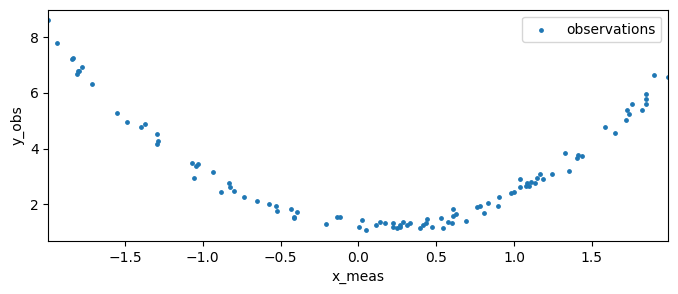

In [125]:
# define a dataset
f_quadratic = lambda x: 1.54 * x**2 - 0.54 * x + 1.3
dataset = Dataset(f=f_quadratic, a=-2, b=2, N=100)

# visualize the observations
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(dataset.x, dataset.y, s=6, label="observations")
ax.set_xlim(dataset.x.min(), dataset.x.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

In [126]:
class HypothesisSpace(nn.Module):
    def __init__(self, a: float, b: float): # <-- add some inputs
        super().__init__()
        self.a = nn.Parameter(torch.tensor([a])) # <-- add some extra parameters
        self.b = nn.Parameter(torch.tensor([b]))

    def forward(self, x: torch.Tensor) -> torch.Tensor: # <-- rewrite the hypothesis space
        return self.a * x + self.b

loss: 3.711: 100%|██████████| 100/100 [00:00<00:00, 486.88it/s]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

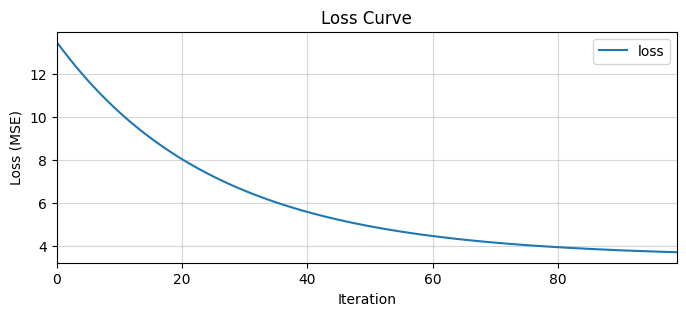

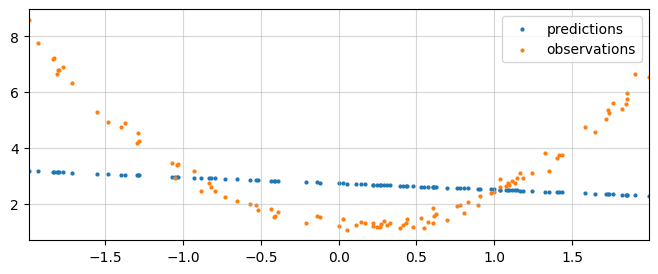

In [127]:
# initial model
model = HypothesisSpace(0.0, 0.0)

# define optimizer : autograd handles computing gradients etc.
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# perform the training loop
model, losses = training_loop(model, optimizer, loss_fn, dataset.x, dataset.y, 100)

# plot loss curve & predictions
plot_loss_curve(losses)
plot_predictions(model, dataset)

We assume in this scenario our optimization and dataset aren't the issue -  however we are still unable to find a suitable solution. In this scenario we would say our approximation error is bounding our performance. Our hypothesis space is clearly far too restrictive - a linear model can't approximate our cubic polynomial well enough. Have a go at re-defining the hypothesis space...

<h2>Section 2. Universal Function Approximators</h2>

Clearly, the process of repeatedly modifying our hypothesis space isn’t a scalable solution for learning highly complex functions. In many real-world tasks, the true relationship between input $\mathcal{X}$ and output $\mathcal{Y}$ is unknown and potentially intricate. We often lack a closed-form expression for this mapping — and even if it exists, we can rarely guess it reliably.

To address this, we turn to more **flexible function classes** capable of approximating a wide range of other functions. Conceptually, this means expanding our hypothesis space $\mathcal{H}$ so that it can more fully exploit the expressive power of our parameter space $\Theta$.

What we want is a universal function approximator: a model that, under certain conditions, can approximate any continuous function on a bounded input domain to arbitrary accuracy, given enough capacity (e.g., sufficient neurons, basis functions, or ensemble components).

Examples of such hypothesis spaces include:
- Perceptrons, which build complex mappings by composing layers of simple nonlinear transformations.
- Kernel methods with radial basis functions, which implicitly project inputs into infinite-dimensional spaces to model nonlinear relationships.

These flexible spaces are what enable modern machine learning models to generalize across diverse tasks — from image recognition to natural language processing — without needing to specify the function form in advance.

> Universal function approximators shifts the burden of function design from the human to the learning algorithm.

Let's have a look at one way to achieve this.



<h3>Recitified Linear Units (ReLU)</h3>

\begin{align*}
  \text{ReLU}(x) = \max(0, x)
\end{align*}

Each ReLU unit introduces a kink — a non-smooth point — at the location where its input changes sign. For a neuron computing $\text{ReLU}(w_i^\top x + b_i)$, this kink occurs at the hyperplane $w_i^\top x + b_i = 0$.

This divides the input space into **two linear regions**:
- One where the neuron is active ($w_i^\top x + b_i > 0$)
- One where it is inactive ($w_i^\top x + b_i \leq 0$)

Lets visualize this.


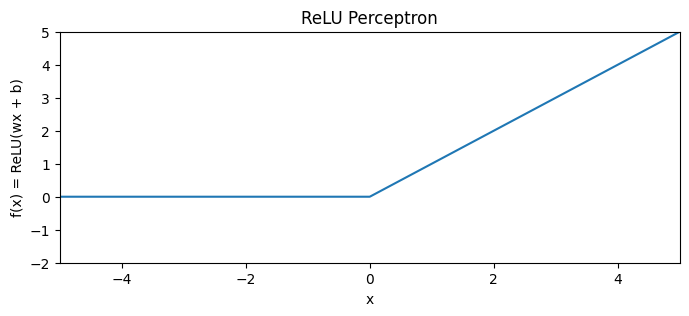

In [128]:
class Perceptron(nn.Module):
    """
    f(x) = ReLU(Wx + B)
    """
    def __init__(self, w: float, b: float):
        super().__init__()
        self.linear = nn.Linear(1, 1)
        self.linear.weight = nn.Parameter(torch.tensor([[float(w)]])) # <-- vary the parameters manually
        self.linear.bias = nn.Parameter(torch.tensor([[float(b)]]))
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.linear(x))

with torch.no_grad():
    x = torch.linspace(-5, 5, 1000).unsqueeze(-1)
    y = Perceptron(1.0, 0.0)(x)

    # plot the perceptron function
    fig, ax = plt.subplots(figsize=(8,3))
    ax.plot(x,y)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(-2, 5)
    ax.set_title("ReLU Perceptron")
    ax.set_xlabel("x")
    ax.set_ylabel("f(x) = ReLU(wx + b)")

We can explore optimizing a single perceptron for our scenario.

loss: 9.297: 100%|██████████| 100/100 [00:00<00:00, 196.30it/s]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

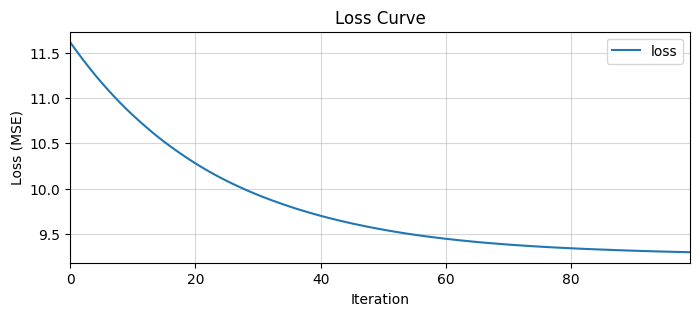

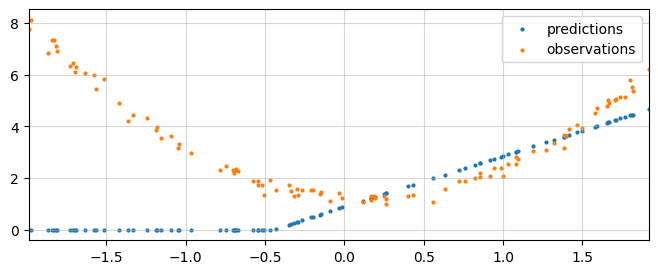

In [130]:
class Perceptron(nn.Module):
    """
    f(x) = ReLU(Wx + B)
    """
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1)

        # specific initialization
        self.linear.weight = nn.Parameter(torch.tensor([[1.0]])) # <-- define a specific starting model init
        self.linear.bias = nn.Parameter(torch.tensor([[0.0]]))

        # random initialization
        # nn.init.uniform_(self.linear.weight, -1, 1)
        # nn.init.uniform_(self.linear.bias, -1, 1)

        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.linear(x))


# define the model, dataset, optimizer, and train the model
model = Perceptron()
dataset = Dataset(f=f_quadratic, a=-2, b=2, N=100)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model, losses = training_loop(model, optimizer, loss_fn, dataset.x, dataset.y, 100)

# visualize the losses and predictions of the trained model
plot_loss_curve(losses)
plot_predictions(model, dataset)

Obviously, a single perceptron is quite limited in what it can approximate — it can only model very simple, linear relationships. However, when we stack or sum multiple ReLU units, the network begins to construct a piecewise linear function, where each ReLU introduces a kink at a specific location in the input space. These kinks partition the domain into regions where different linear behaviors can be expressed, allowing the network to model increasingly complex functions.

With enough ReLU units — even in just a single hidden layer — we can approximate any continuous piecewise linear function. As we increase the number of hidden units, we gain the ability to fit more kinks, and thereby approximate more intricate functions with higher fidelity. In the theoretical limit, an infinitely wide ReLU network becomes a universal function approximator - under appropriate conditions (such as proper weight scaling and initialization).

Let's explore this.





(<Figure size 800x300 with 1 Axes>, <Axes: >)

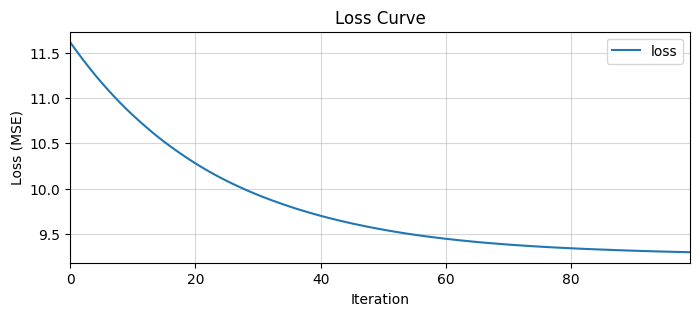

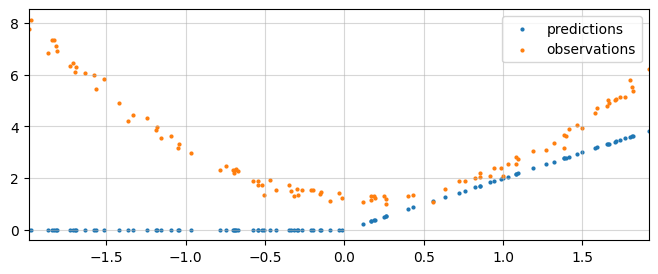

In [131]:
class PerceptronLayer(nn.Module):
    def __init__(self, N: int = 1):
        super().__init__()
        self.perceptrons = nn.ModuleList([Perceptron() for _ in range(N)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # y_pred = Perceptron0(x) + ... + PerceptronN(x)
        y_pred = 0
        for perceptron in self.perceptrons:
            y_pred = y_pred + perceptron(x)
        return y_pred

model = PerceptronLayer(N=2) # <-- lets define 2 perceptrons initially

# lets modify the weights manually
with torch.no_grad():
    model.perceptrons[0].linear.weight = nn.Parameter(torch.tensor([[1.0]])) # <-- tweak these manually
    model.perceptrons[0].linear.bias = nn.Parameter(torch.tensor([[0.0]]))
    model.perceptrons[1].linear.weight = nn.Parameter(torch.tensor([[1.0]]))
    model.perceptrons[1].linear.bias = nn.Parameter(torch.tensor([[0.0]]))

plot_loss_curve(losses)
plot_predictions(model, dataset)

Clearly, tweaking these parameters is an arduous task - lets train the model instead and see what happens.

loss: 8.514: 100%|██████████| 100/100 [00:00<00:00, 343.93it/s]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

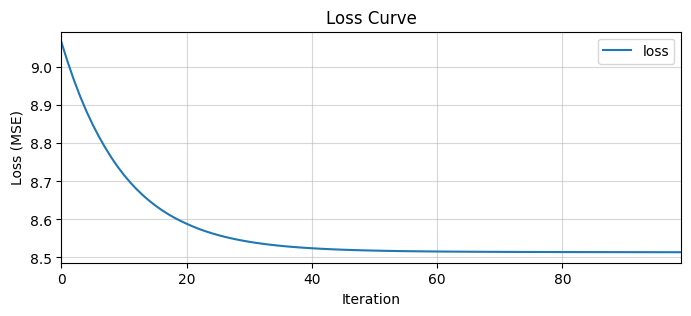

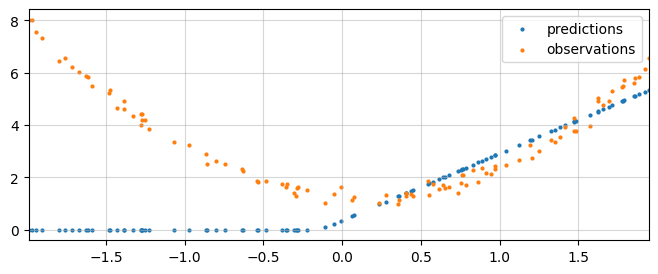

In [133]:
model = PerceptronLayer(N=2) # <-- lets define 2 perceptrons initially
dataset = Dataset(f=f_quadratic, a=-2, b=2, N=100)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model, losses = training_loop(model, optimizer, loss_fn, dataset.x, dataset.y, 100)

plot_loss_curve(losses)
plot_predictions(model, dataset)

Does your model approximate the function well? If not, what do you think is the issue?

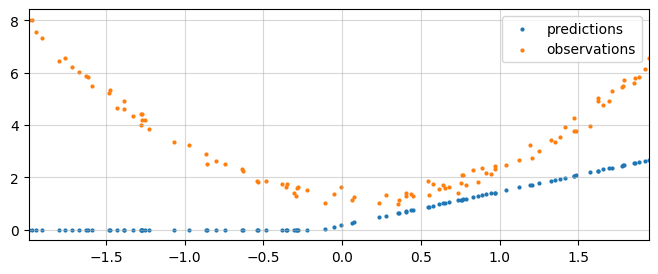

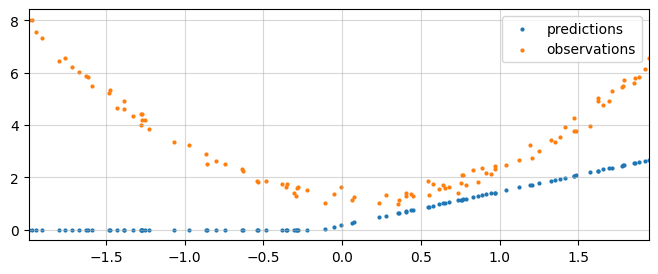

In [134]:
for perceptron in model.perceptrons:
    _ = plot_predictions(perceptron, dataset)

<h3>More complex functions</h3>

So clearly there are some considerations when designing a ReLU network - the basis function we choose and the initialization of the parameters clearly impact the optimization procedure...

However, we've managed to get this function approximation process working. Let's consider another slighty more complicated target function:

\begin{align*}
  f^{*}(x) = \left\{ \mathbb{R} \rightarrow \mathbb{R} \,|\, f(x) = 2.04x^{3} + 1.54x^{2} - 0.54x + 1.3 \right\} \tag{1.1}
\end{align*}

Text(0, 0.5, 'y_obs')

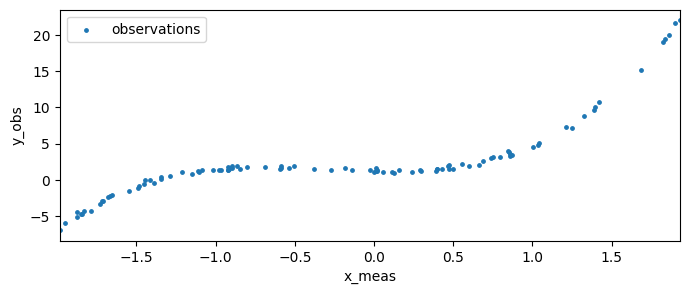

In [137]:
# define a dataset
f_cubic = lambda x: 2.04 * x**3 + 1.54 * x**2 - 0.54 * x + 1.3
dataset = Dataset(f=f_cubic, a=-2, b=2, N=100)

# visualize the observations
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(dataset.x, dataset.y, s=6, label="observations")
ax.set_xlim(dataset.x.min(), dataset.x.max())
ax.legend(loc="best")
ax.set_xlabel("x_meas")
ax.set_ylabel("y_obs")

In [138]:
class Perceptron(nn.Module):
    """
    f(x) = ReLU(Wx + B)
    """
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1) # <-- torch handles initialization using `kaiming` init for us
        self.act = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.act(self.linear(x))


class PerceptronLayer(nn.Module):
    def __init__(self, N: int = 1):
        super().__init__()
        self.perceptrons = nn.ModuleList([Perceptron() for _ in range(N)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        y_pred = 0
        for perceptron in self.perceptrons:
            y_pred = y_pred + perceptron(x)
        return y_pred

loss: 2.620: 100%|██████████| 1000/1000 [00:05<00:00, 175.47it/s]


(<Figure size 800x300 with 1 Axes>, <Axes: >)

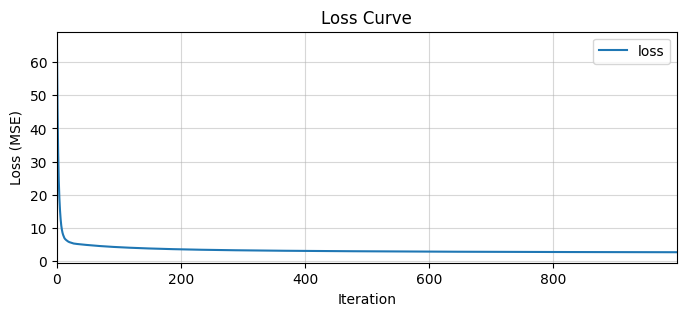

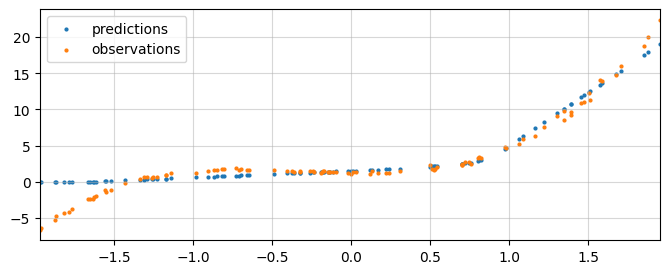

In [143]:
model = PerceptronLayer(N=20) # <-- lets define 2 perceptrons initially
dataset = Dataset(f=f_cubic, a=-2, b=2, N=100)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # <-- how do different optimizers impact performance
model, losses = training_loop(model, optimizer, loss_fn, dataset.x, dataset.y, 1000)

plot_loss_curve(losses)
plot_predictions(model, dataset)